In [1]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
from models.deepflybrain import DeepFlyBrain

device = torch.device(f'cuda:0')
print(f"Using {device} device")

Using cuda:0 device


In [5]:
with open('configs/config_dfb-furlanis.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

'checkpoints/dfb_furlanis_2025-05-29_17-28-01'

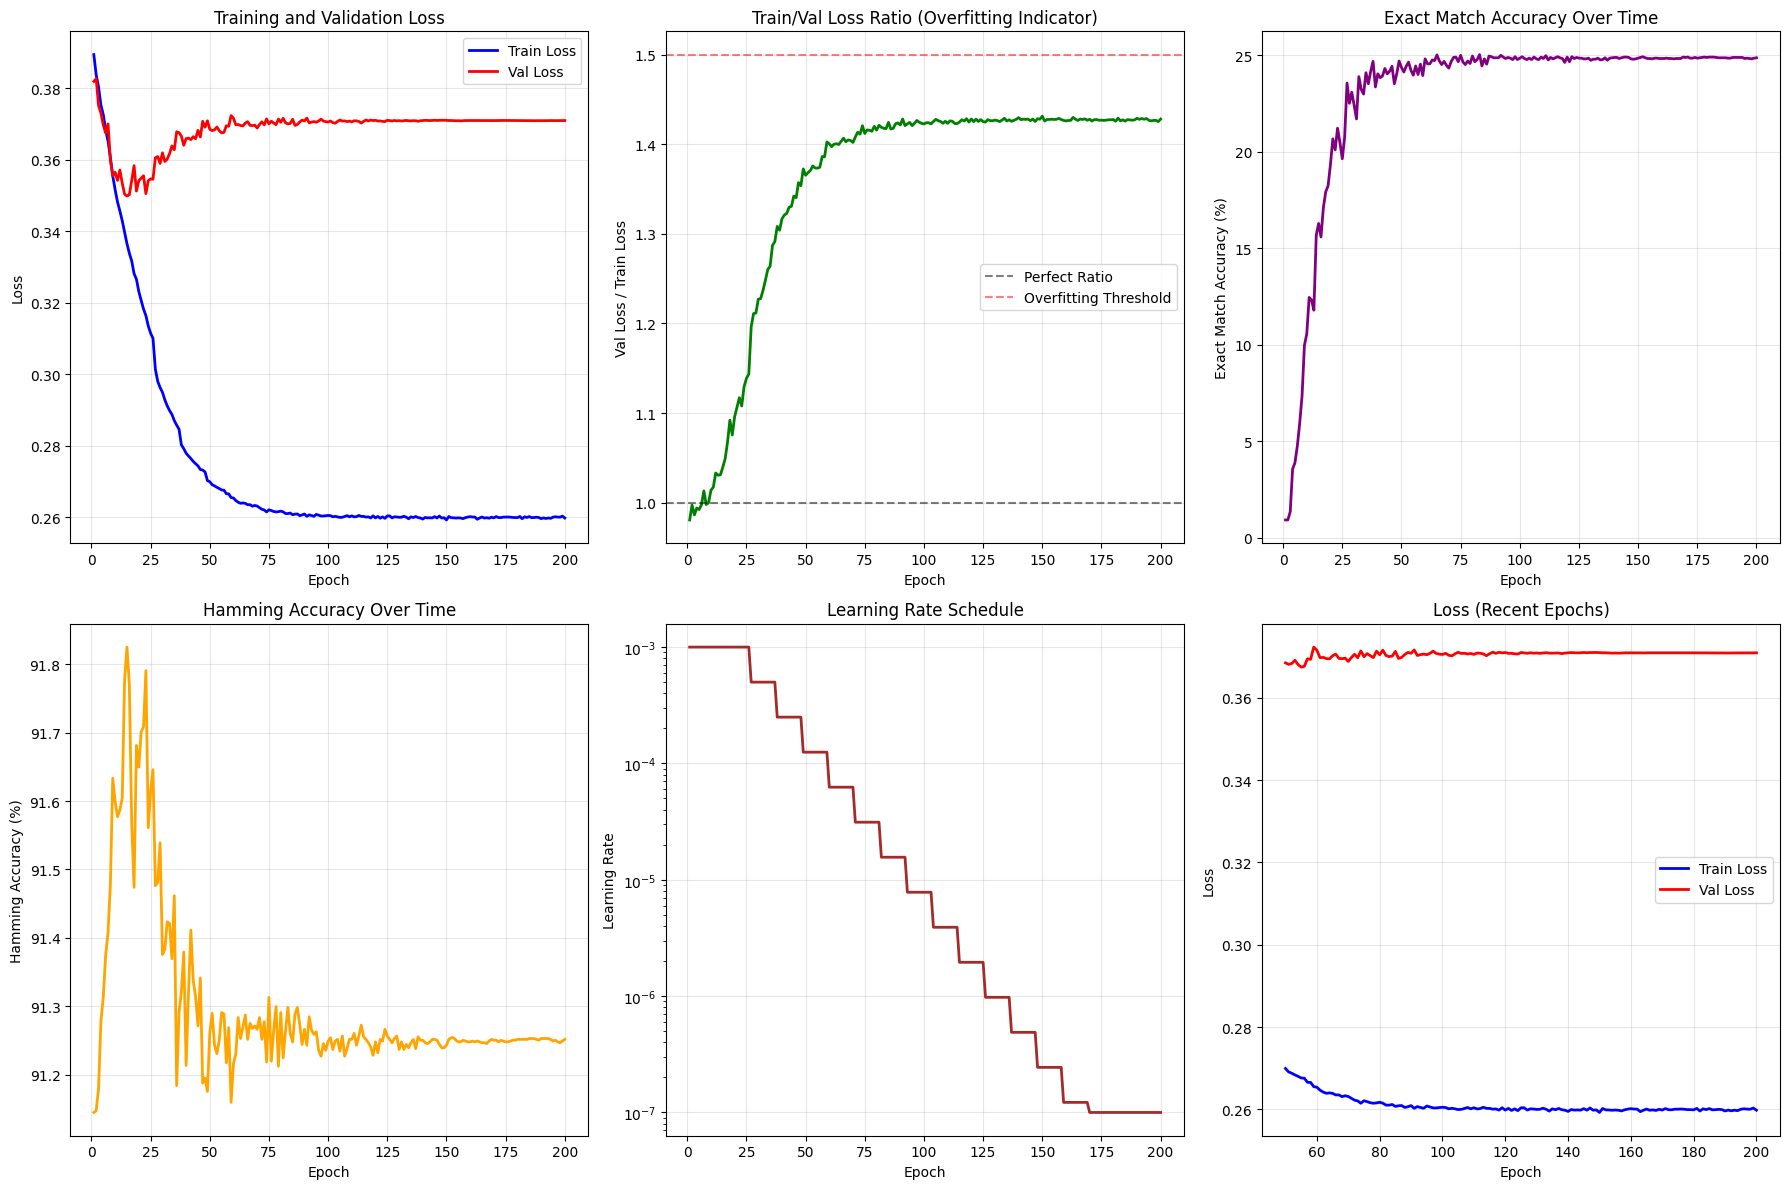

Training Summary:
Initial Train Loss: 0.389425
Final Train Loss: 0.259777
Initial Val Loss: 0.381907
Final Val Loss: 0.370976
Best Val Loss: 0.349856 (Epoch 15)
Best Exact Match Acc: 0.2504 (Epoch 83)
Best Hamming Acc: 0.9183 (Epoch 15)
Final Train/Val Ratio: 1.428


In [6]:
# Add this cell to your notebook to plot training curves

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

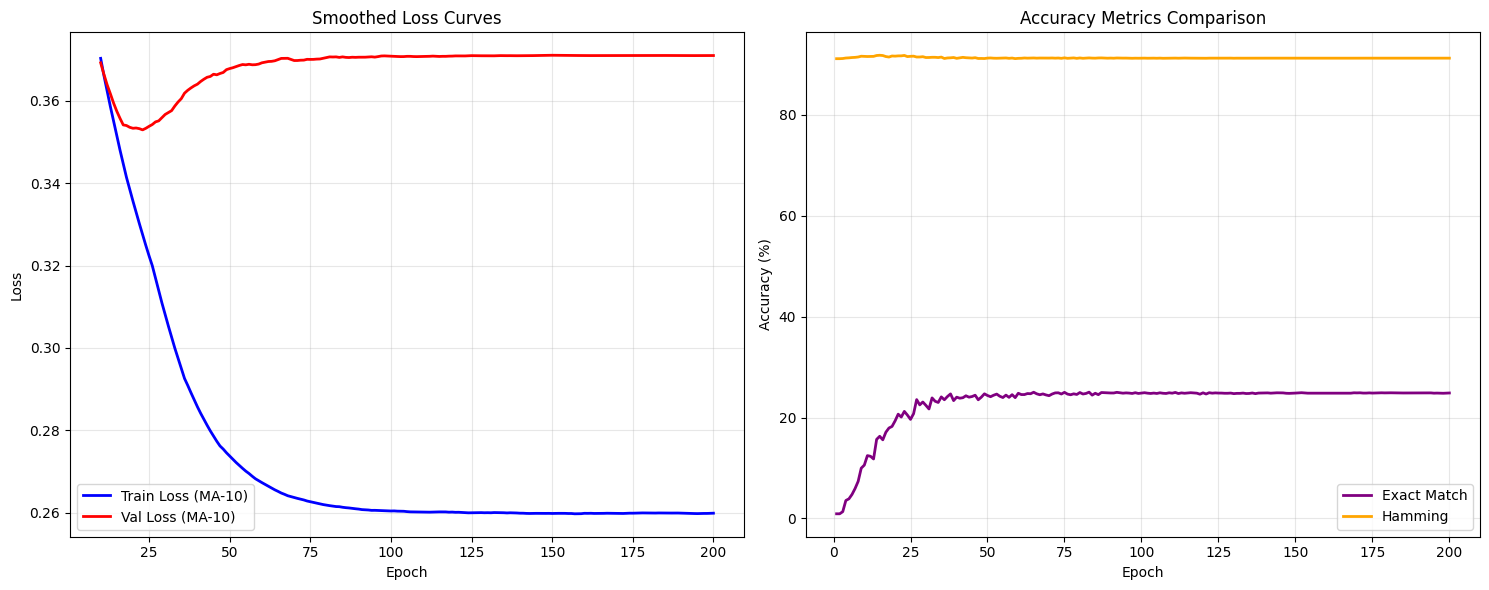

In [7]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

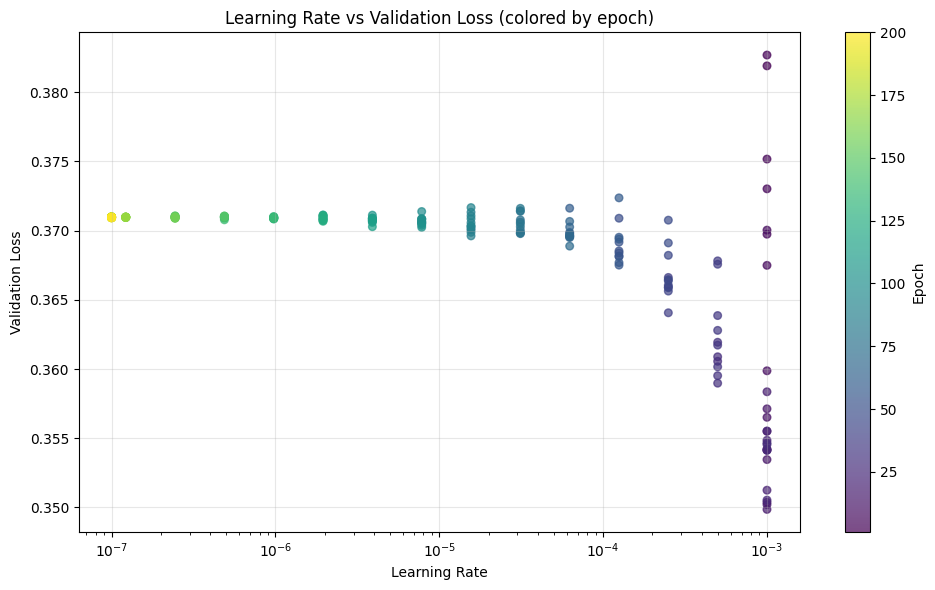

In [8]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [9]:
# Training phases analysis
print("Training Phases Analysis:")
print("=" * 50)

# Phase 1: Initial training (epochs 1-50)
phase1 = training_df[training_df['epoch'] <= 50]
print(f"Phase 1 (Epochs 1-50):")
print(f"  Loss reduction: {phase1['train_loss'].iloc[0]:.4f} → {phase1['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase1['val_loss'].iloc[0]:.4f} → {phase1['val_loss'].iloc[-1]:.4f}")
print(f"  Accuracy improvement: {phase1['exact_match_acc'].iloc[0]:.4f} → {phase1['exact_match_acc'].iloc[-1]:.4f}")

# Phase 2: Middle training (epochs 51-200)
phase2 = training_df[(training_df['epoch'] > 50) & (training_df['epoch'] <= 200)]
print(f"\nPhase 2 (Epochs 51-200):")
print(f"  Loss reduction: {phase2['train_loss'].iloc[0]:.4f} → {phase2['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase2['val_loss'].iloc[0]:.4f} → {phase2['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase2['exact_match_acc'].max():.4f}")

# Phase 3: Fine-tuning (epochs 201-300)
phase3 = training_df[training_df['epoch'] > 200]
print(f"\nPhase 3 (Epochs 201-300):")
print(f"  Loss reduction: {phase3['train_loss'].iloc[0]:.4f} → {phase3['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase3['val_loss'].iloc[0]:.4f} → {phase3['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase3['exact_match_acc'].max():.4f}")

# Identify potential overfitting
overfitting_epochs = training_df[training_df['train_val_ratio'] > 1.5]
if len(overfitting_epochs) > 0:
    print(f"\nPotential overfitting detected in {len(overfitting_epochs)} epochs:")
    print(f"  First occurrence: Epoch {overfitting_epochs['epoch'].iloc[0]}")
    print(f"  Worst ratio: {overfitting_epochs['train_val_ratio'].max():.3f} at epoch {overfitting_epochs.loc[overfitting_epochs['train_val_ratio'].idxmax(), 'epoch']}")
else:
    print(f"\nNo significant overfitting detected (all ratios < 1.5)")

Training Phases Analysis:
Phase 1 (Epochs 1-50):
  Loss reduction: 0.3894 → 0.2699
  Val loss reduction: 0.3819 → 0.3685
  Accuracy improvement: 0.0092 → 0.2437

Phase 2 (Epochs 51-200):
  Loss reduction: 0.2691 → 0.2598
  Val loss reduction: 0.3682 → 0.3710
  Best accuracy: 0.2504

Phase 3 (Epochs 201-300):


IndexError: single positional indexer is out-of-bounds

In [10]:
# Resume model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/final_model.pth')

model = DeepFlyBrain(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [12]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [13]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [15]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.002330017 0.99995005
Prediction shape: (36190, 15)
Target shape: (36190, 15)


In [16]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0865
Topic 1: 0.0902
Topic 2: 0.0964
Topic 3: 0.0912
Topic 4: 0.0930
Topic 5: 0.0882
Topic 6: 0.0824
Topic 7: 0.0924
Topic 8: 0.0866
Topic 9: 0.0883
Topic 10: 0.0894
Topic 11: 0.0912
Topic 12: 0.0888
Topic 13: 0.0897
Topic 14: 0.0885


In [17]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[32565   495]
 [  860  2270]]

Topic 1:
[[32744   183]
 [ 1238  2025]]

Topic 2:
[[32554   149]
 [ 1005  2482]]

Topic 3:
[[32317   573]
 [  685  2615]]

Topic 4:
[[32686   137]
 [ 1134  2233]]

Topic 5:
[[32784   214]
 [ 1234  1958]]

Topic 6:
[[32273   936]
 [  711  2270]]

Topic 7:
[[32788    58]
 [ 1558  1786]]

Topic 8:
[[32990    67]
 [ 1603  1530]]

Topic 9:
[[32708   286]
 [ 1126  2070]]

Topic 10:
[[32761   192]
 [  483  2754]]

Topic 11:
[[32496   393]
 [  769  2532]]

Topic 12:
[[32935    43]
 [ 1813  1399]]

Topic 13:
[[32881    62]
 [ 1722  1525]]

Topic 14:
[[32702   286]
 [  544  2658]]



Evaluating 15 topics...
Evaluating topic 0
Topic 0 - auROC: 0.9404, auPR: 0.8078, F1: 0.7701


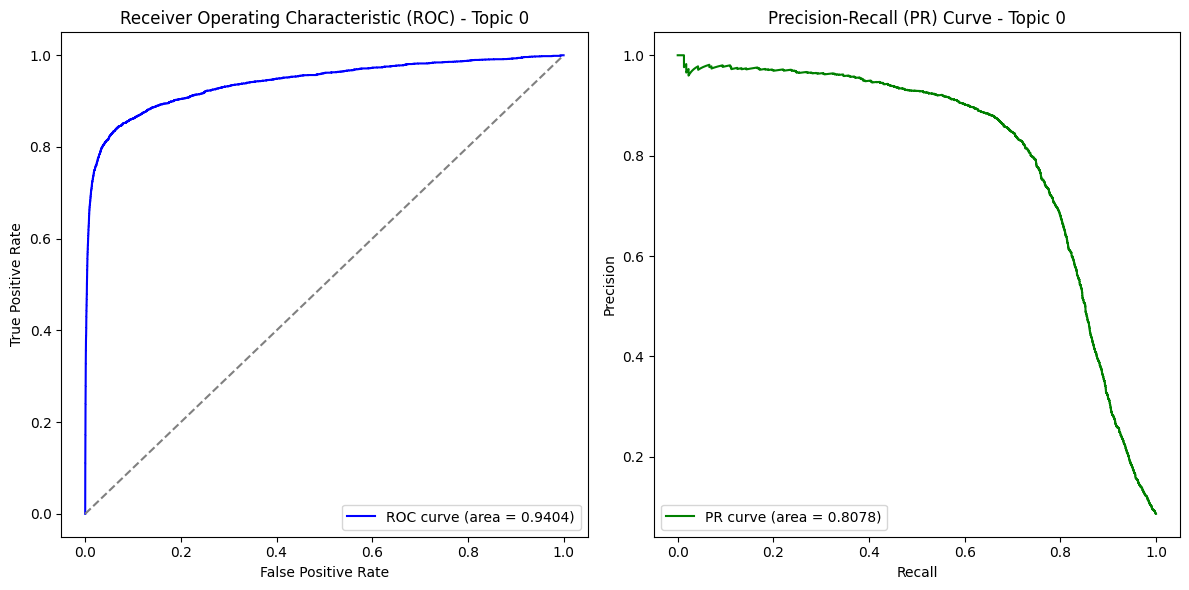

Evaluating topic 1
Topic 1 - auROC: 0.9401, auPR: 0.8262, F1: 0.7403


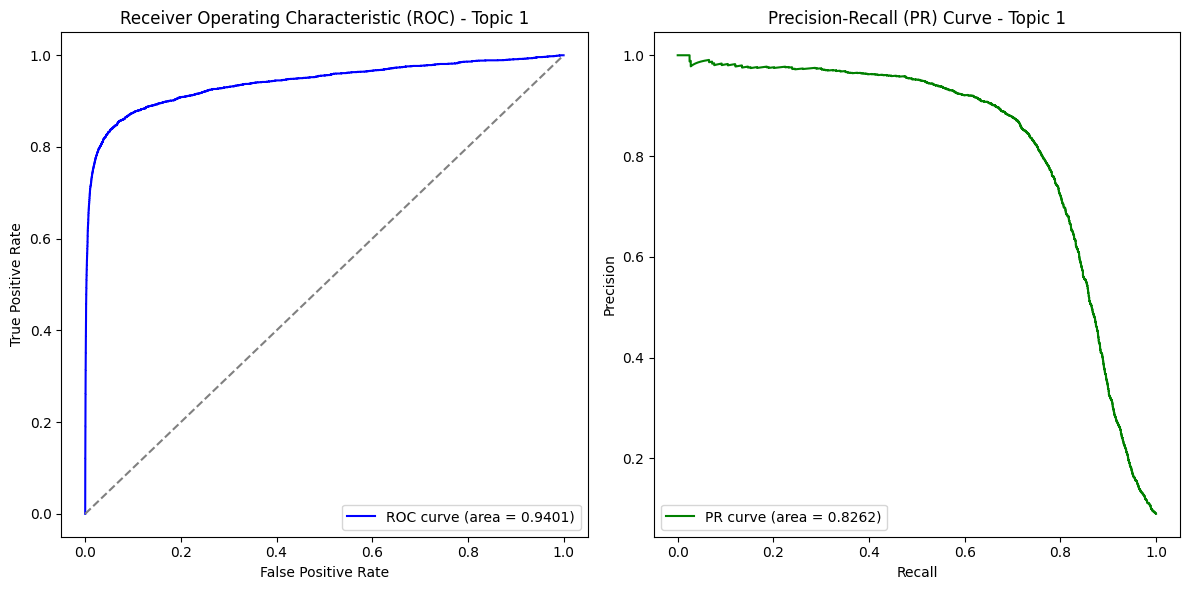

Evaluating topic 2
Topic 2 - auROC: 0.9601, auPR: 0.8797, F1: 0.8114


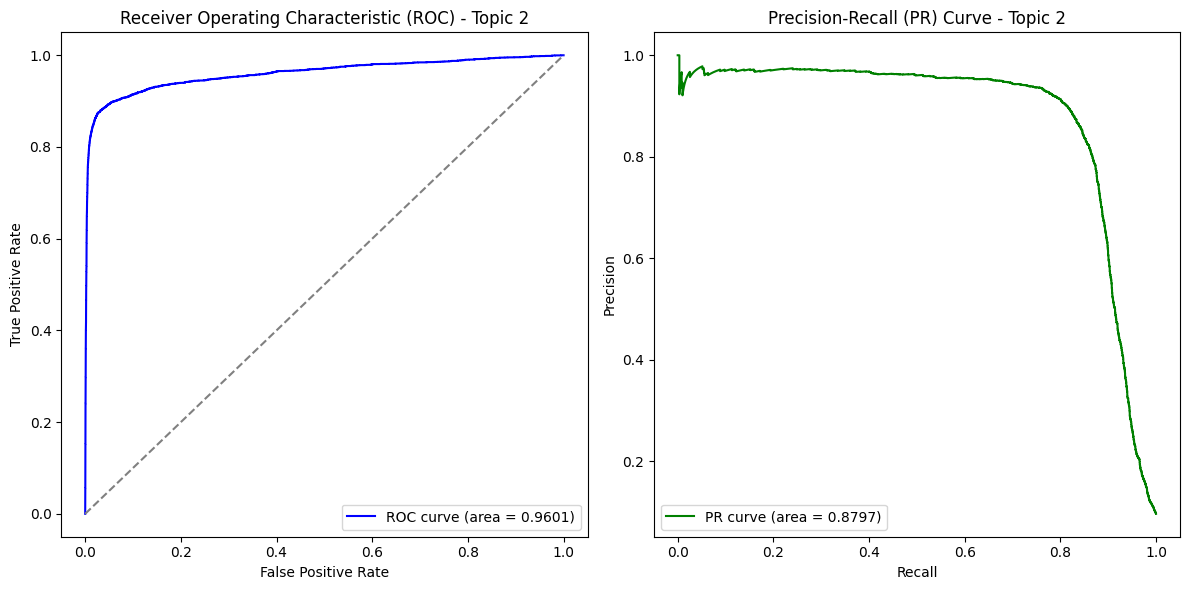

Evaluating topic 3
Topic 3 - auROC: 0.9641, auPR: 0.8646, F1: 0.8061


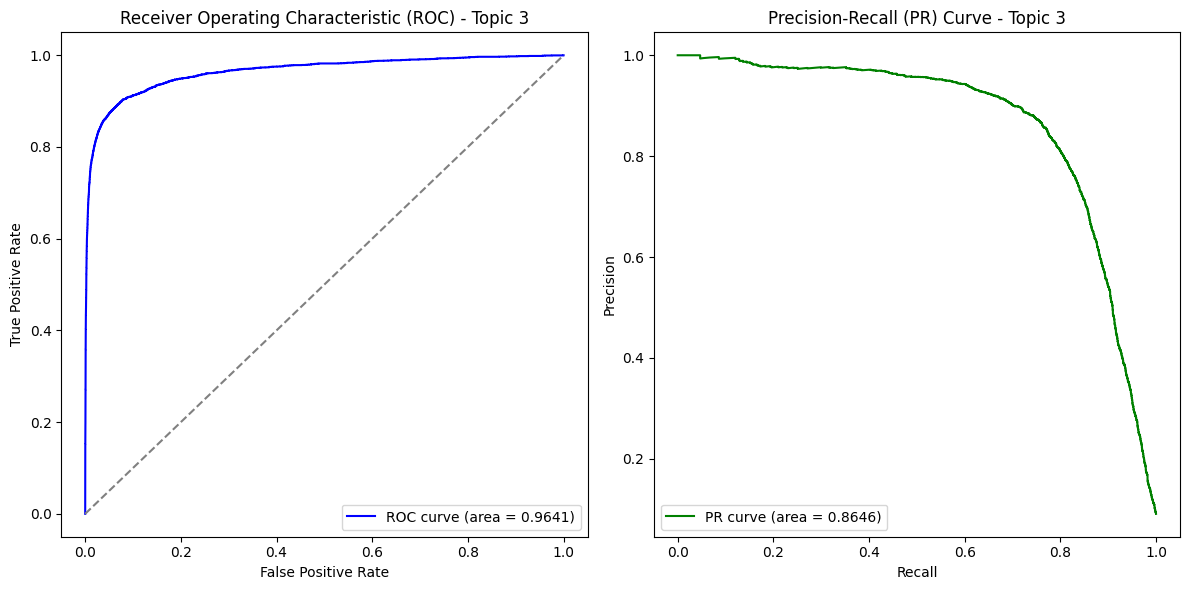

Evaluating topic 4
Topic 4 - auROC: 0.9592, auPR: 0.8730, F1: 0.7785


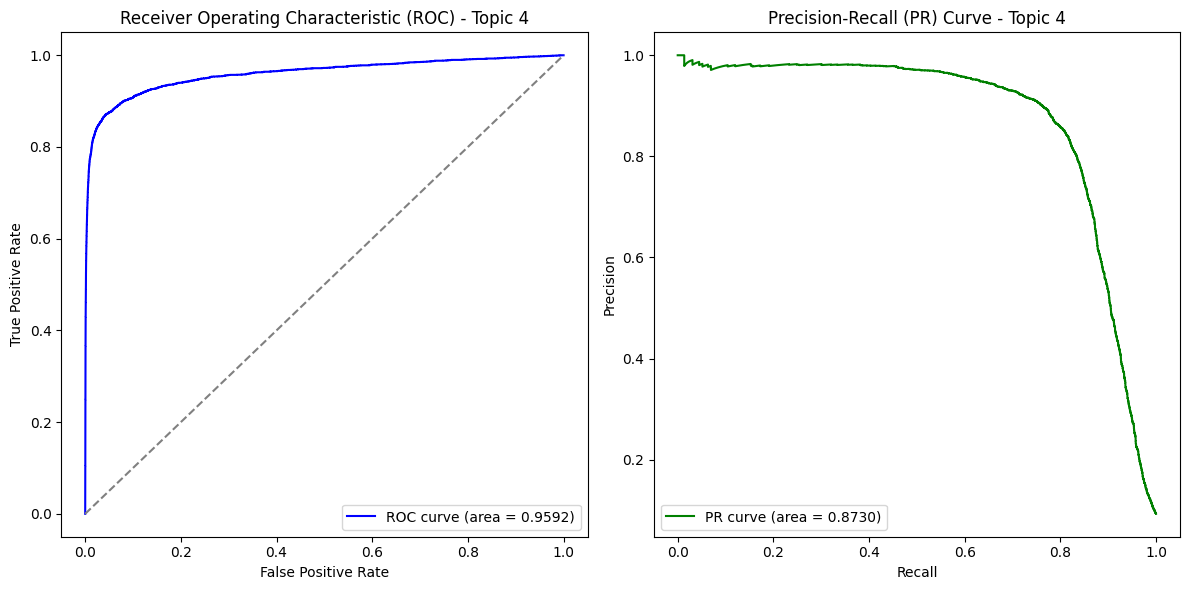

Evaluating topic 5
Topic 5 - auROC: 0.9298, auPR: 0.7978, F1: 0.7301


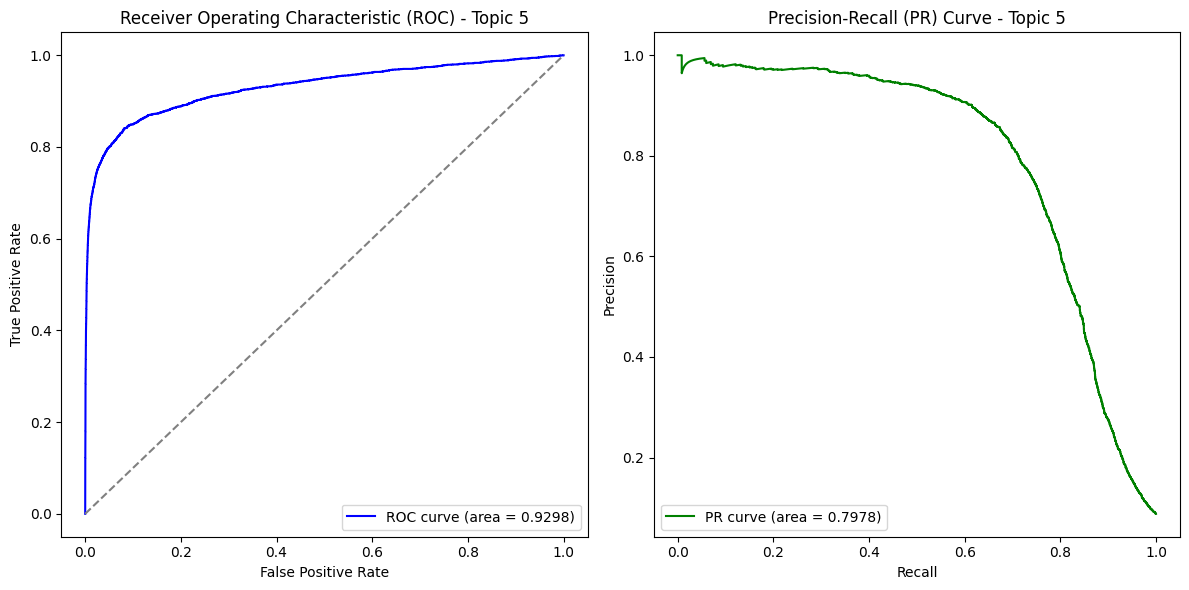

Evaluating topic 6
Topic 6 - auROC: 0.9438, auPR: 0.7952, F1: 0.7338


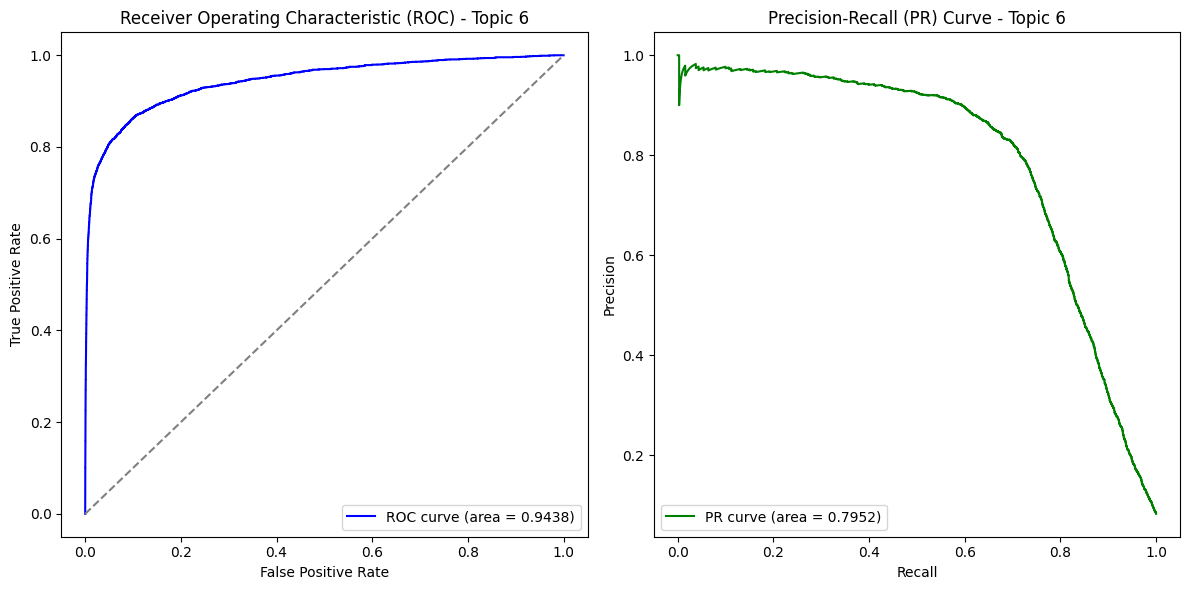

Evaluating topic 7
Topic 7 - auROC: 0.9400, auPR: 0.8432, F1: 0.6885


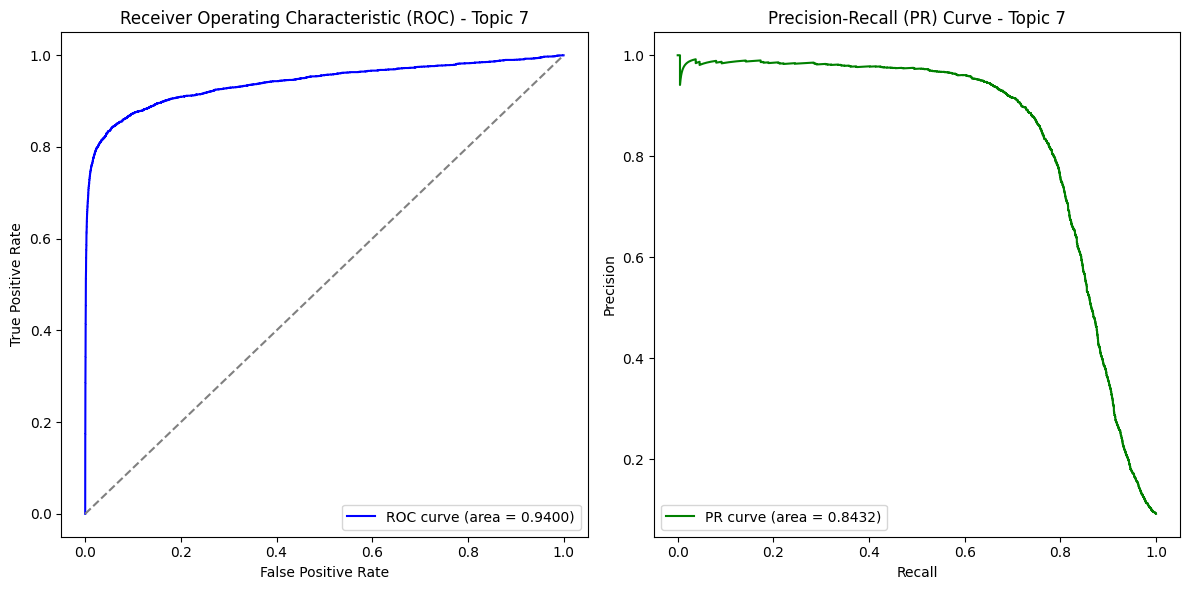

Evaluating topic 8
Topic 8 - auROC: 0.9213, auPR: 0.7864, F1: 0.6469


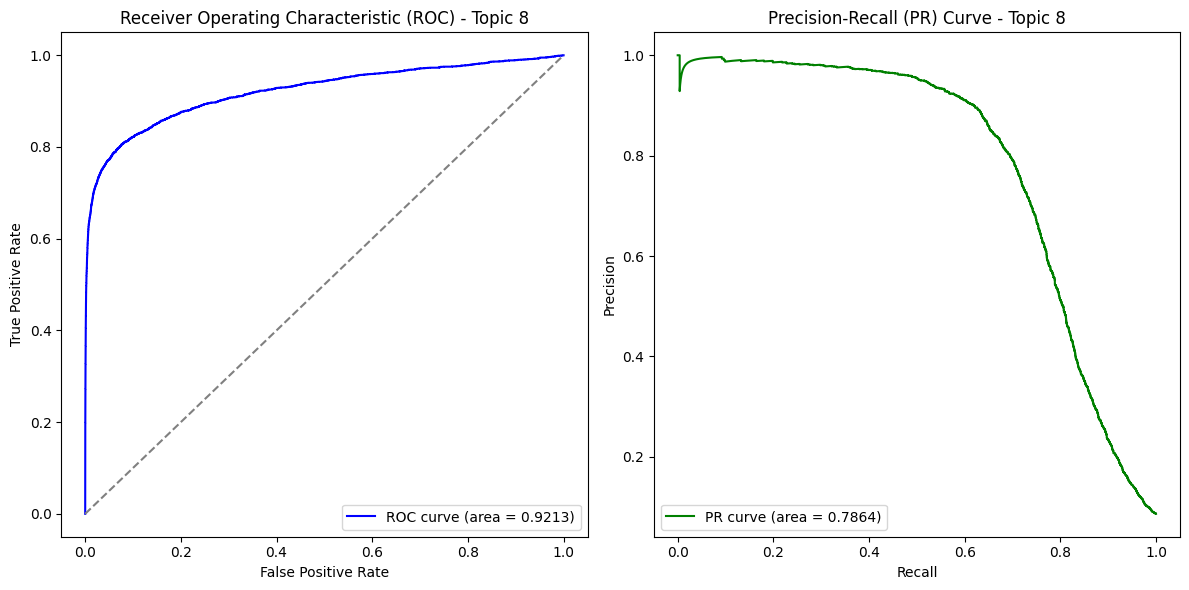

Evaluating topic 9
Topic 9 - auROC: 0.9405, auPR: 0.7968, F1: 0.7457


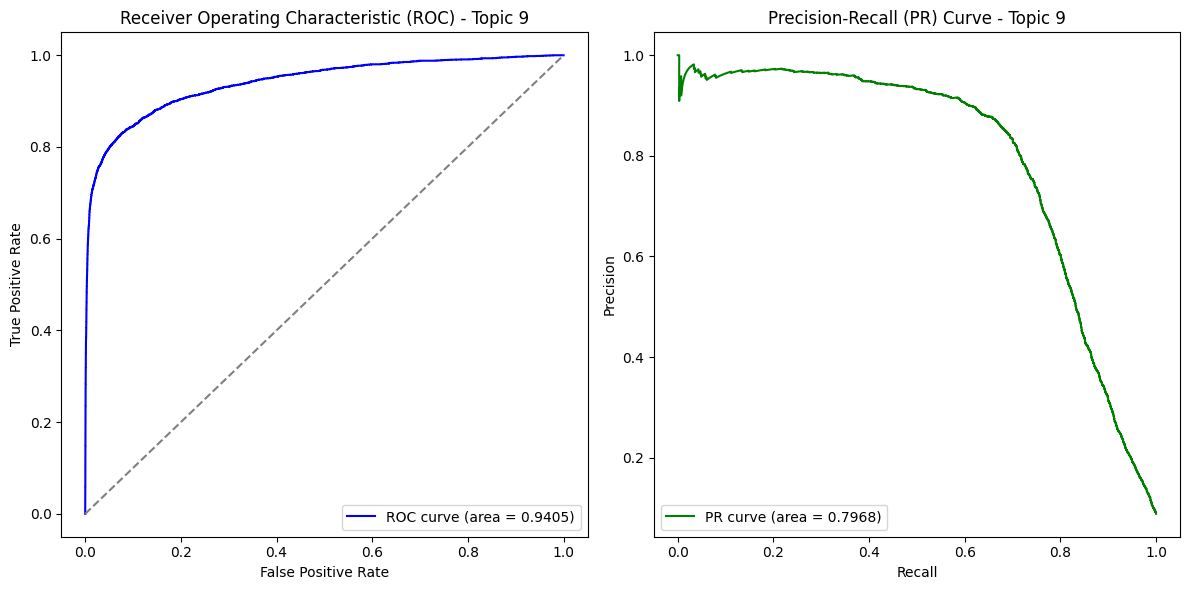

Evaluating topic 10
Topic 10 - auROC: 0.9803, auPR: 0.9324, F1: 0.8908


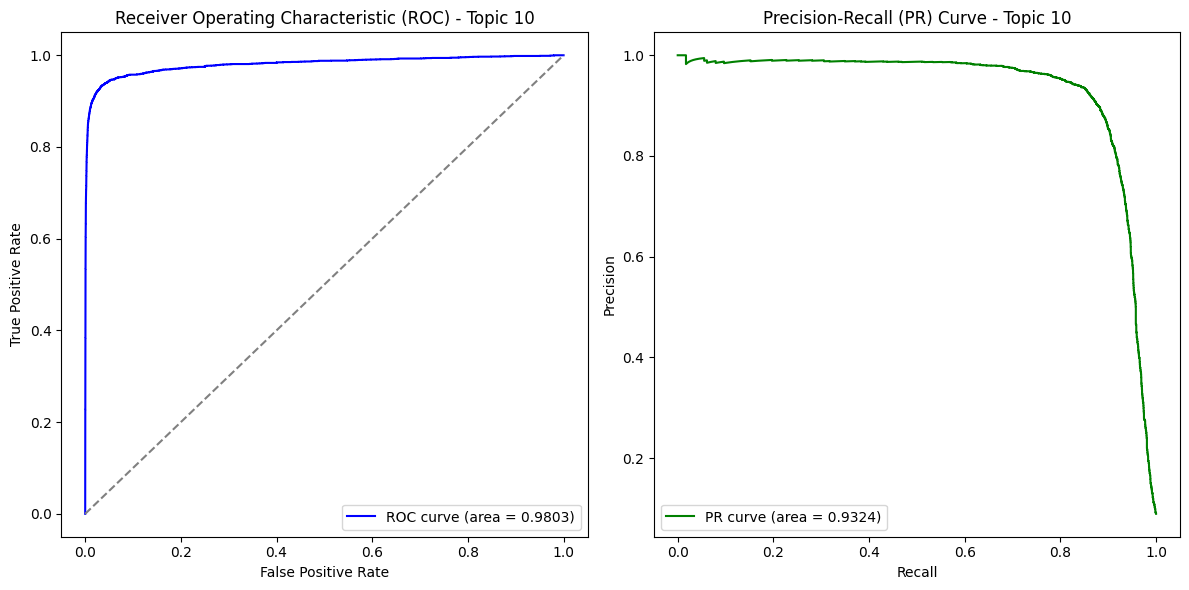

Evaluating topic 11
Topic 11 - auROC: 0.9575, auPR: 0.8619, F1: 0.8134


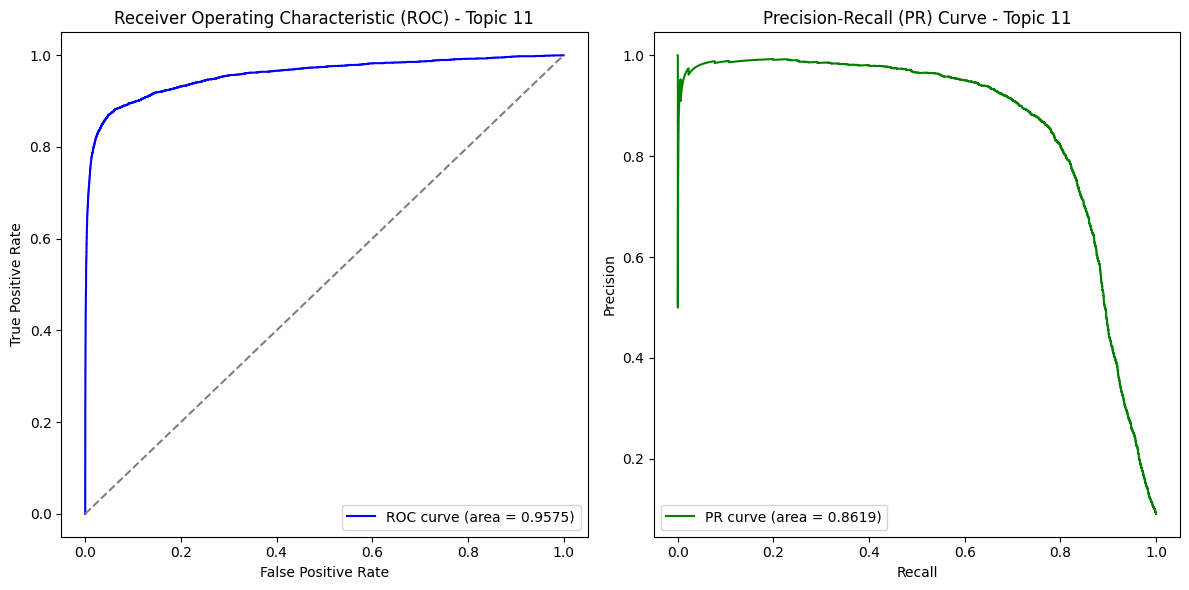

Evaluating topic 12
Topic 12 - auROC: 0.9207, auPR: 0.8025, F1: 0.6012


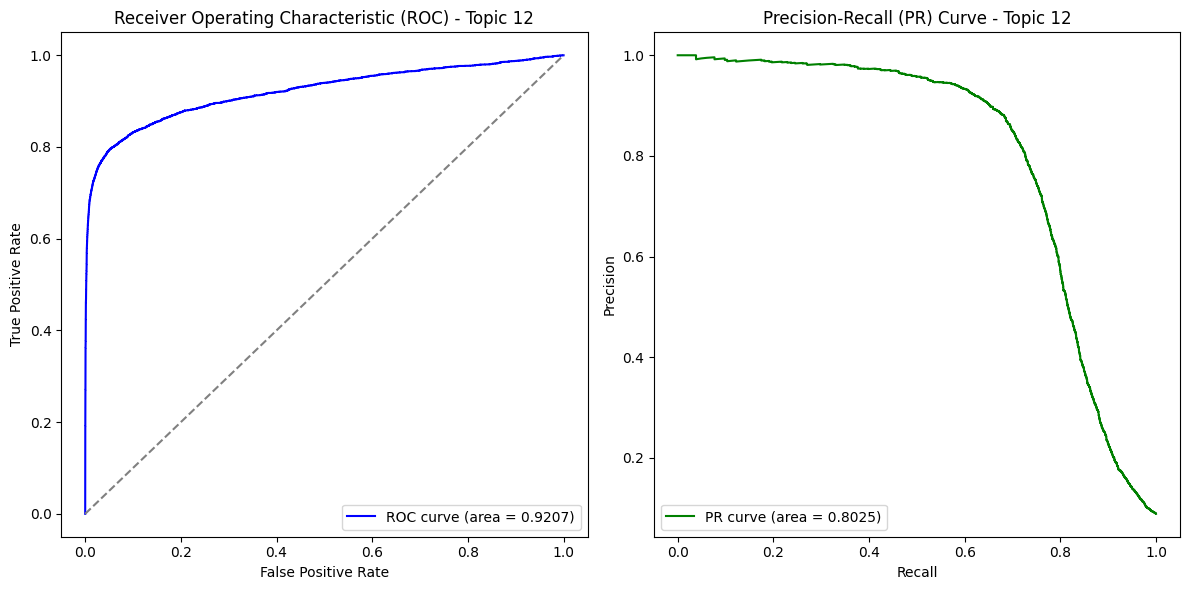

Evaluating topic 13
Topic 13 - auROC: 0.9207, auPR: 0.7966, F1: 0.6309


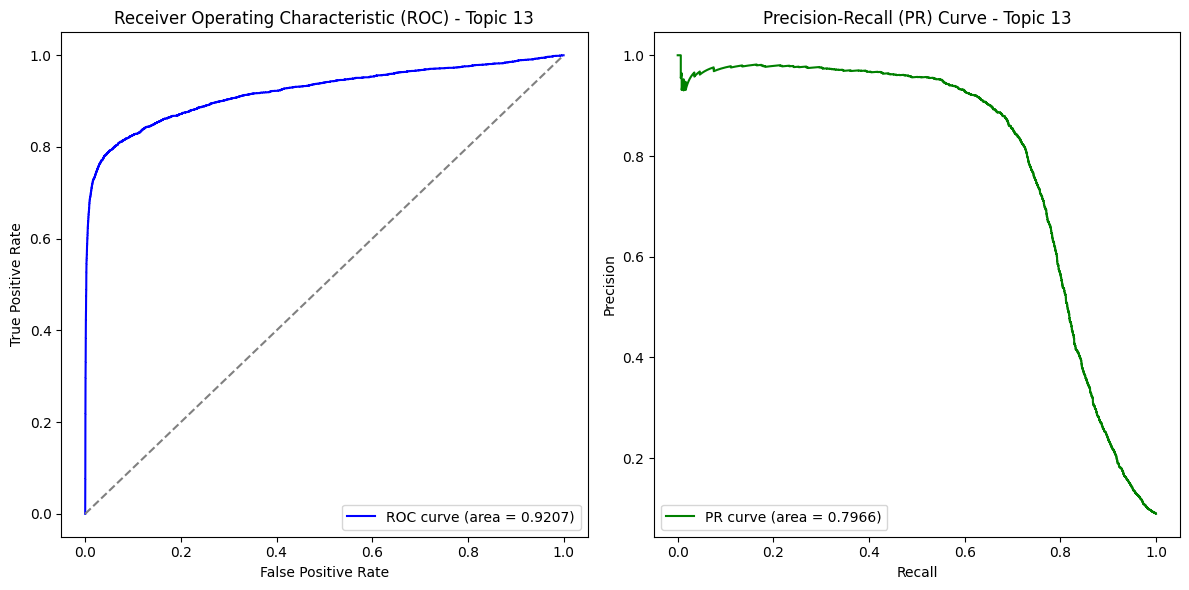

Evaluating topic 14
Topic 14 - auROC: 0.9758, auPR: 0.9144, F1: 0.8650


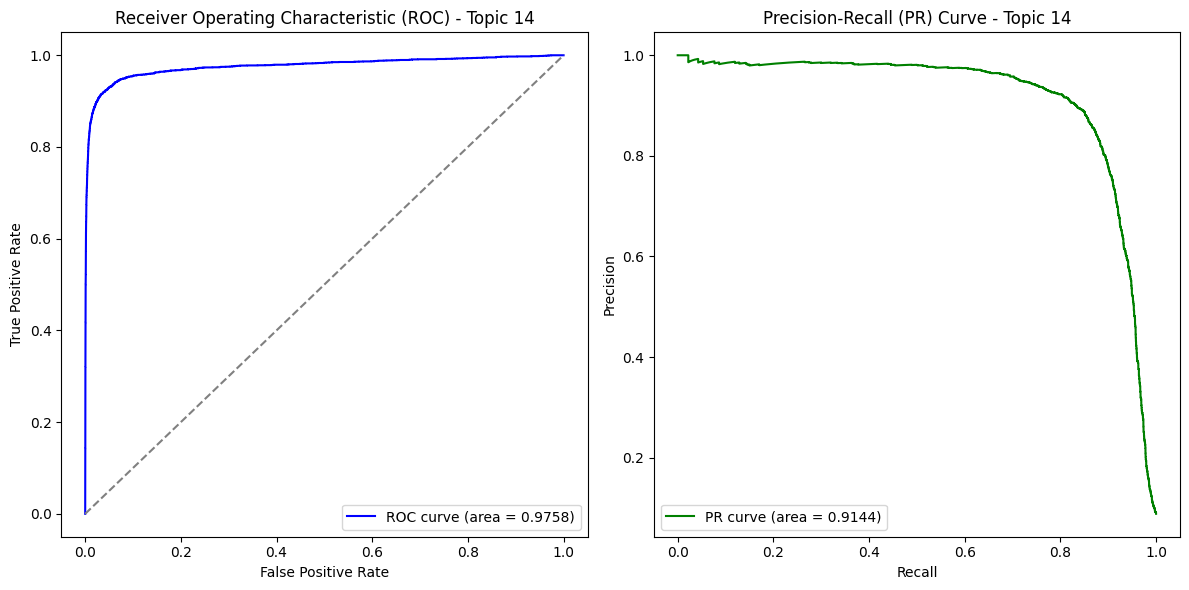

In [18]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [19]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.9463 ± 0.0186
Mean auPR: 0.8386 ± 0.0454
Mean F1: 0.7502 ± 0.0803
Exact Match Accuracy: 0.6292
Hamming Accuracy: 0.9621


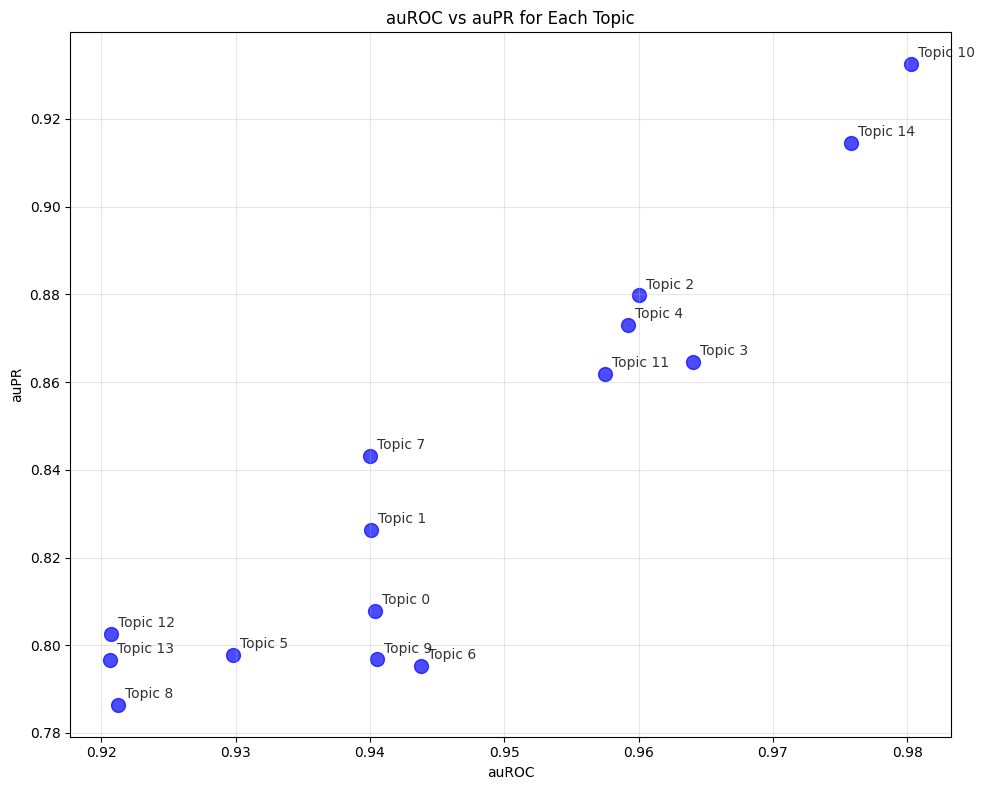

In [20]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

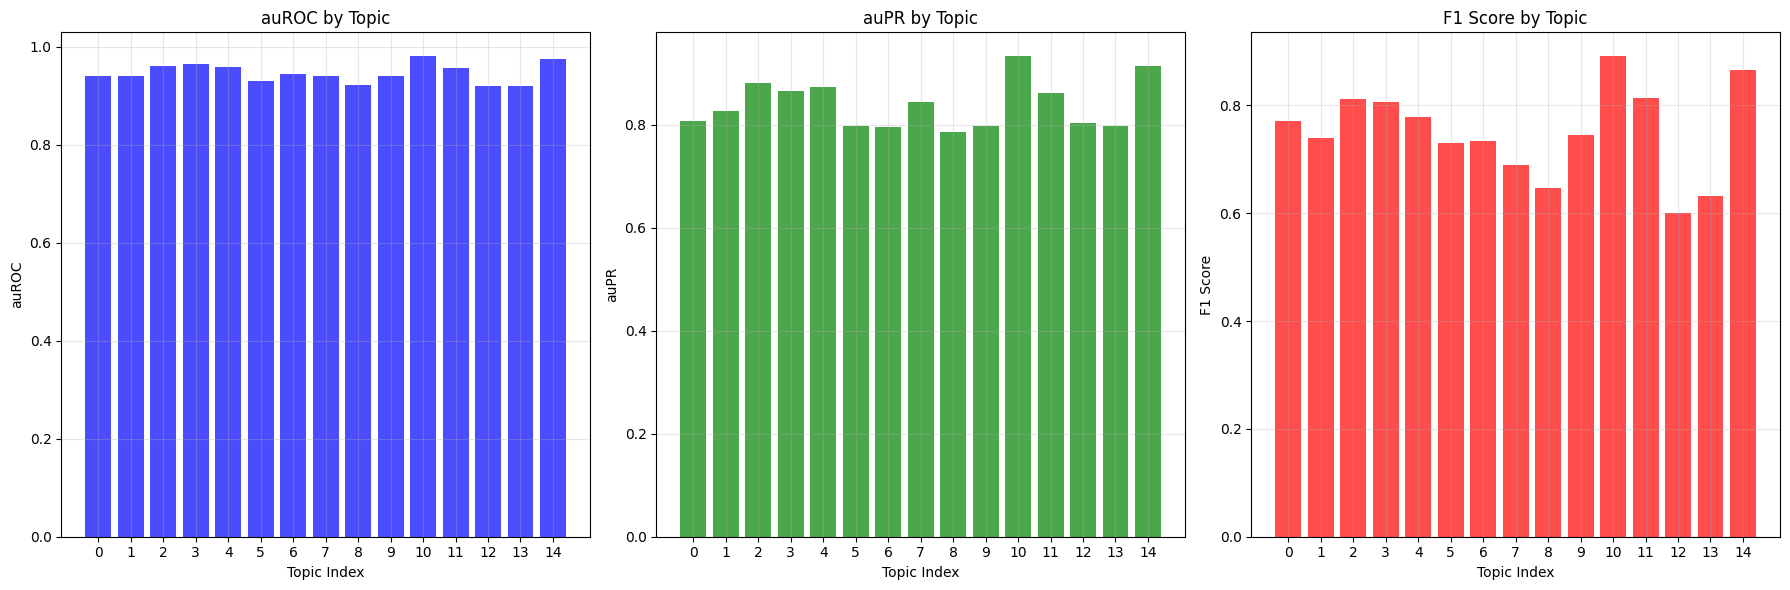

In [21]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

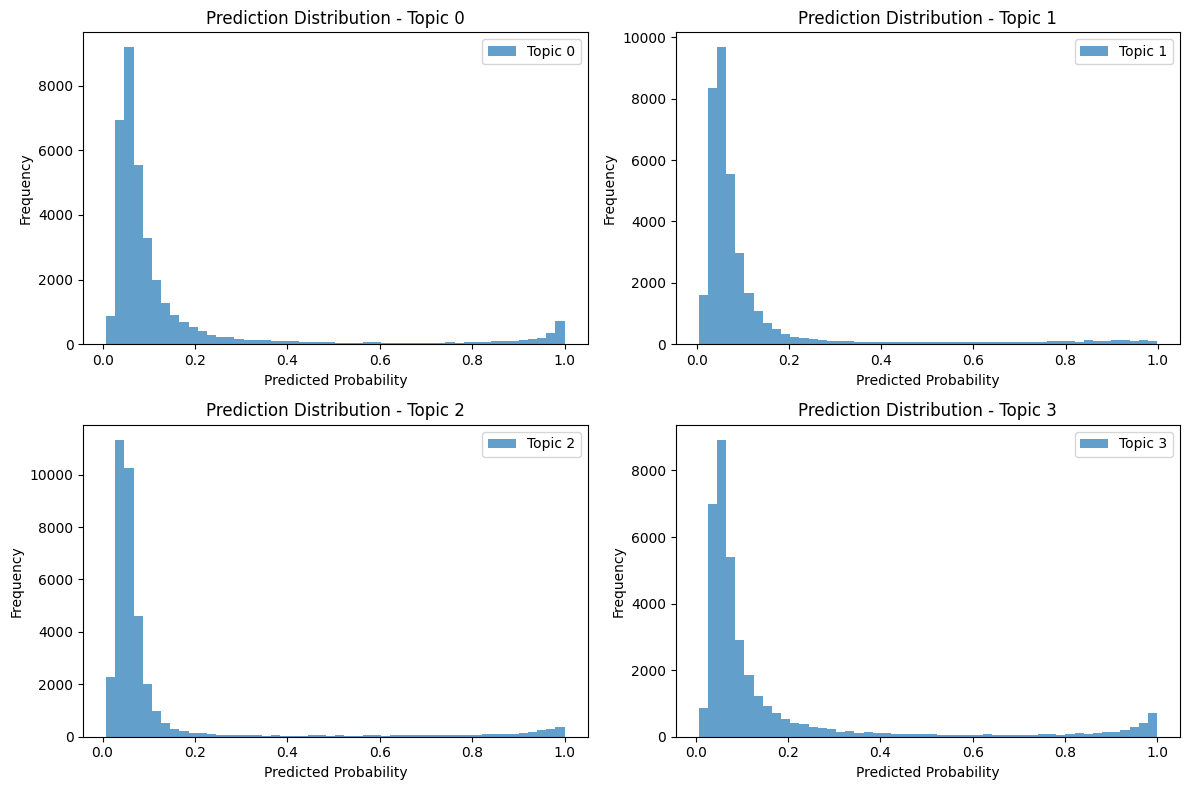


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.06808962 0.06279013 0.09746648 0.1121901  0.02379271 0.03328018
 0.10977843 0.04512074 0.03700813 0.7991912  0.04825995 0.2716747
 0.05987415 0.1274917  0.0408948 ]
  Actual:    [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]

Sample 1:
  Predicted: [0.04743772 0.05545545 0.7675899  0.06221703 0.04959365 0.04210729
 0.03911147 0.02425284 0.02721243 0.06317355 0.06025989 0.29512376
 0.02801861 0.11807653 0.04743997]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.03862645 0.02048555 0.03894454 0.05866649 0.02898716 0.01327073
 0.9951302  0.03023815 0.03186609 0.02671625 0.05608112 0.06243047
 0.03689386 0.02443168 0.02917165]
  Actual:    [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]

Sample 3:
  Predicted: [0.05956712 0.60012513 0.02022054 0.03684424

In [22]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [23]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [24]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.0030954105 0.99995005
Prediction shape: (5429, 15)
Target shape: (5429, 15)


In [25]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0866
Topic 1: 0.0952
Topic 2: 0.0890
Topic 3: 0.0941
Topic 4: 0.0904
Topic 5: 0.0869
Topic 6: 0.0807
Topic 7: 0.0860
Topic 8: 0.0904
Topic 9: 0.0939
Topic 10: 0.0932
Topic 11: 0.0989
Topic 12: 0.0864
Topic 13: 0.0928
Topic 14: 0.0849


In [26]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[4718  241]
 [ 333  137]]

Topic 1:
[[4814   98]
 [ 427   90]]

Topic 2:
[[4881   65]
 [ 298  185]]

Topic 3:
[[4651  267]
 [ 295  216]]

Topic 4:
[[4872   66]
 [ 358  133]]

Topic 5:
[[4867   90]
 [ 408   64]]

Topic 6:
[[4645  346]
 [ 287  151]]

Topic 7:
[[4937   25]
 [ 429   38]]

Topic 8:
[[4909   29]
 [ 469   22]]

Topic 9:
[[4790  129]
 [ 423   87]]

Topic 10:
[[4824   99]
 [ 173  333]]

Topic 11:
[[4692  200]
 [ 343  194]]

Topic 12:
[[4935   25]
 [ 452   17]]

Topic 13:
[[4888   37]
 [ 480   24]]

Topic 14:
[[4839  129]
 [ 160  301]]



Evaluating 15 topics...
Evaluating topic 0
Topic 0 - auROC: 0.7697, auPR: 0.2955, F1: 0.3231


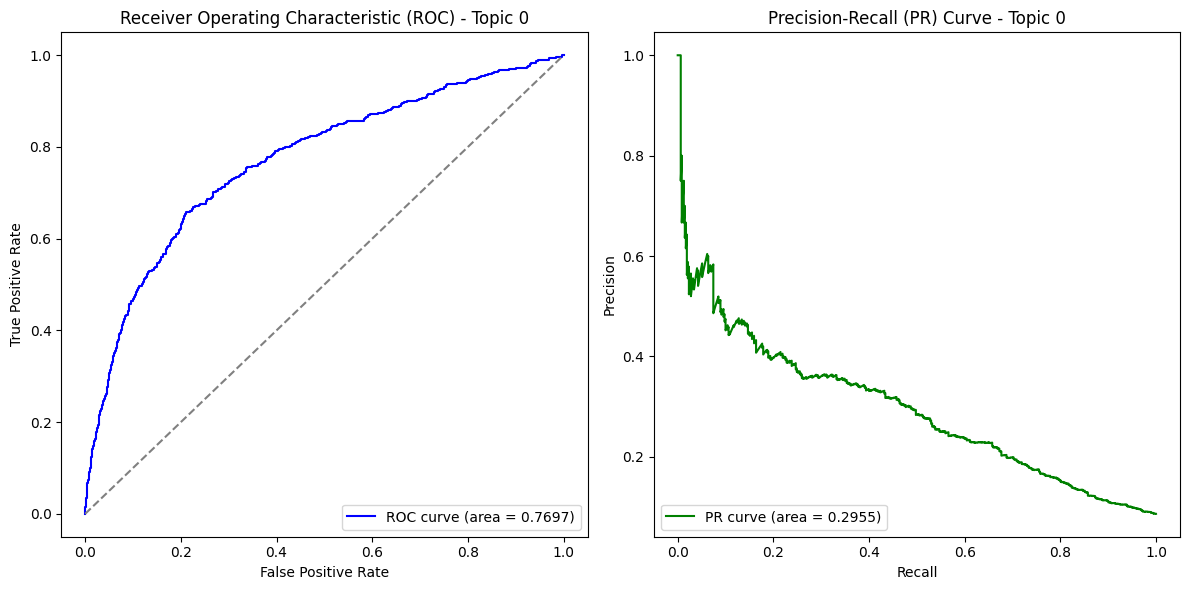

Evaluating topic 1
Topic 1 - auROC: 0.7678, auPR: 0.3309, F1: 0.2553


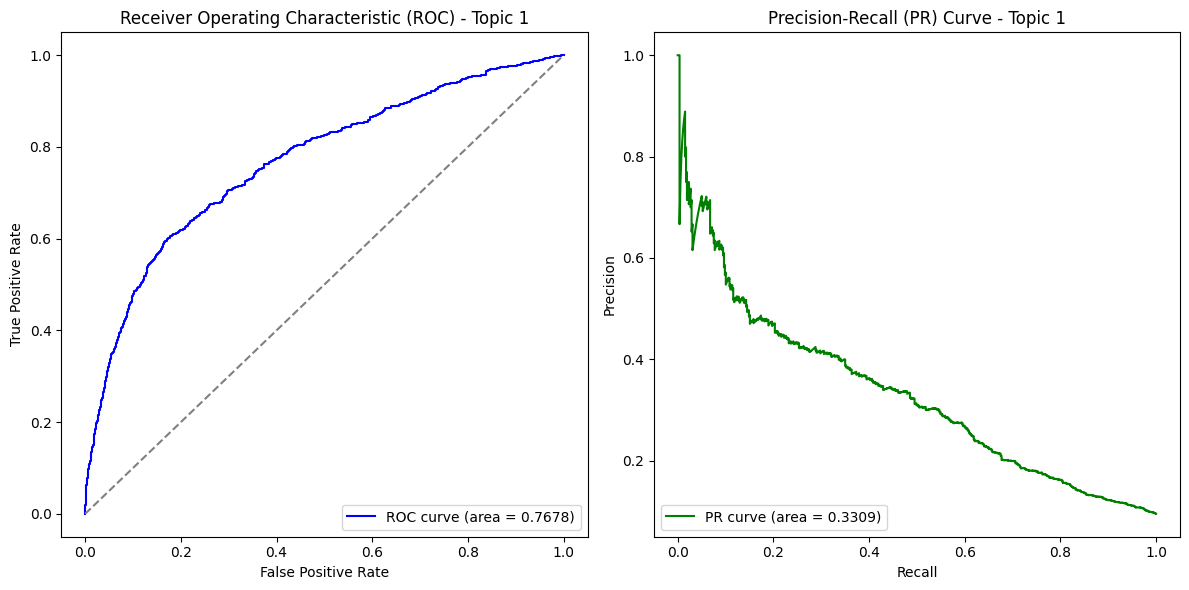

Evaluating topic 2
Topic 2 - auROC: 0.8201, auPR: 0.5093, F1: 0.5048


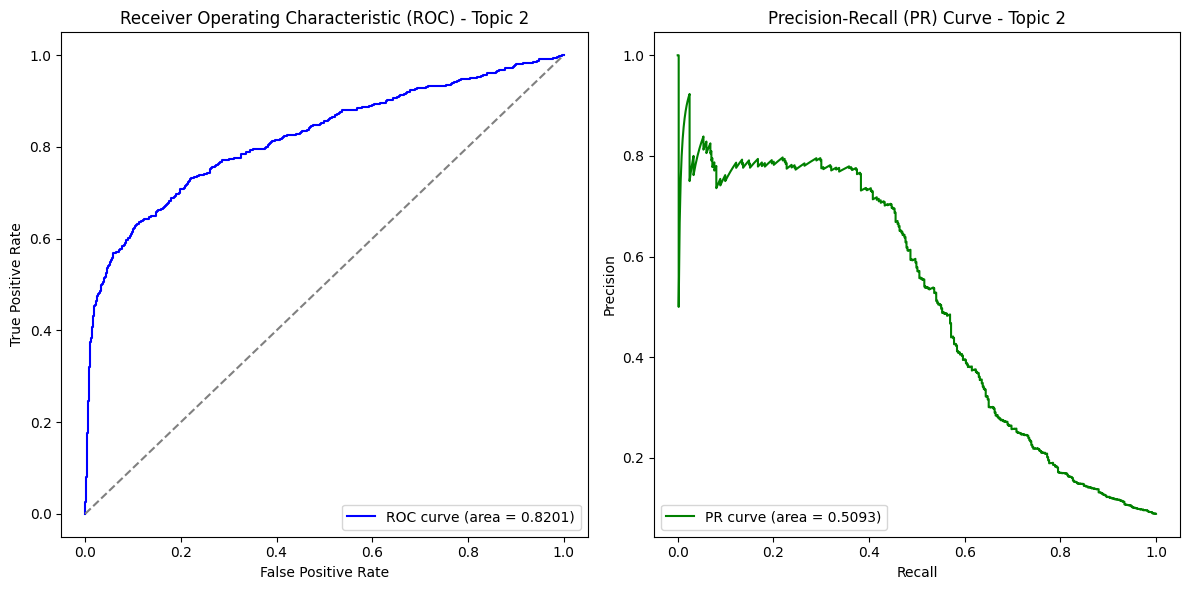

Evaluating topic 3
Topic 3 - auROC: 0.8435, auPR: 0.4334, F1: 0.4346


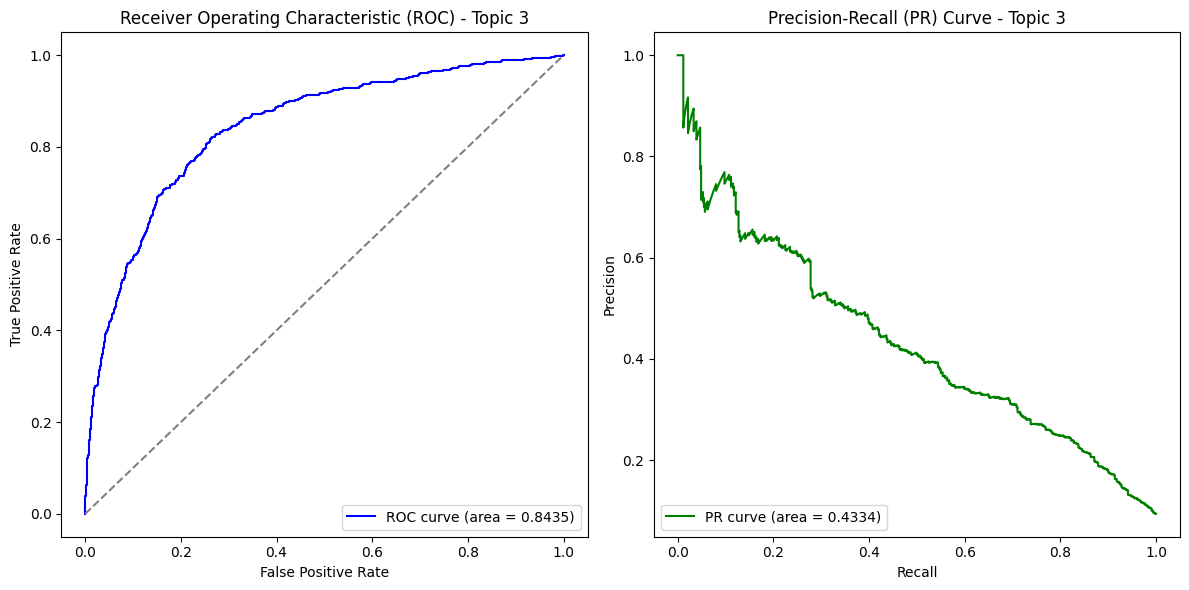

Evaluating topic 4
Topic 4 - auROC: 0.8452, auPR: 0.4931, F1: 0.3855


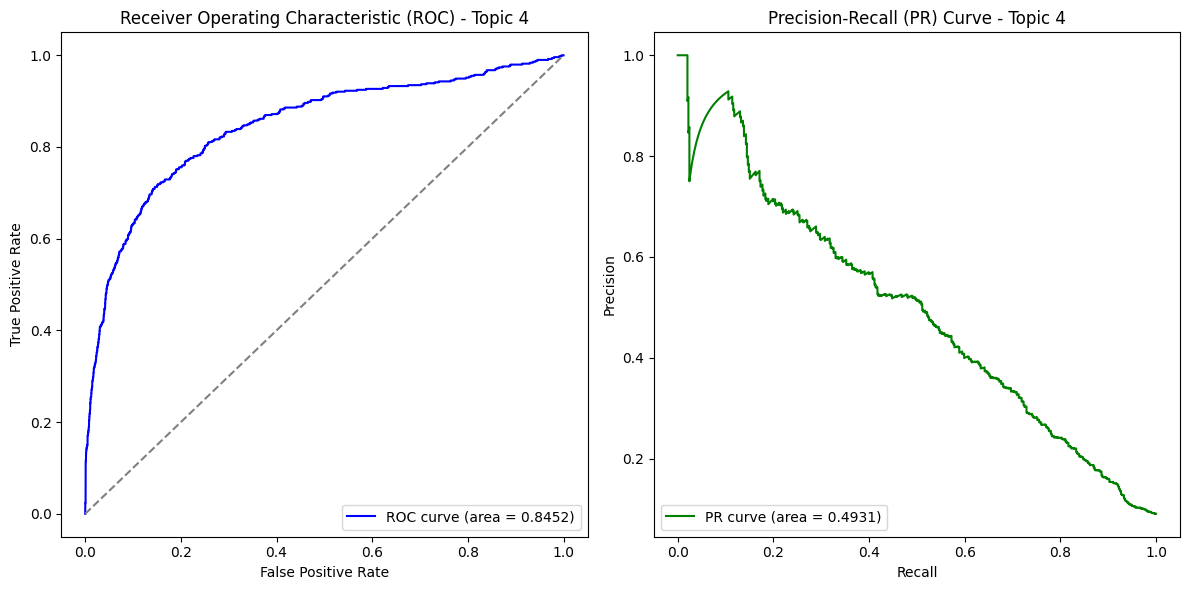

Evaluating topic 5
Topic 5 - auROC: 0.7333, auPR: 0.2478, F1: 0.2045


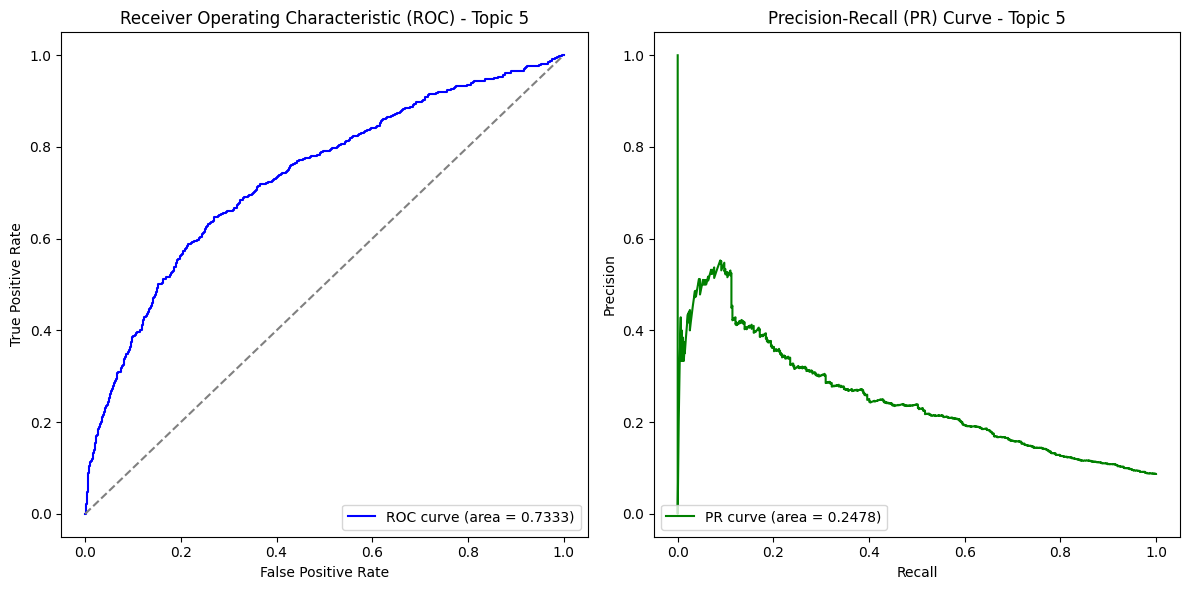

Evaluating topic 6
Topic 6 - auROC: 0.7704, auPR: 0.2955, F1: 0.3230


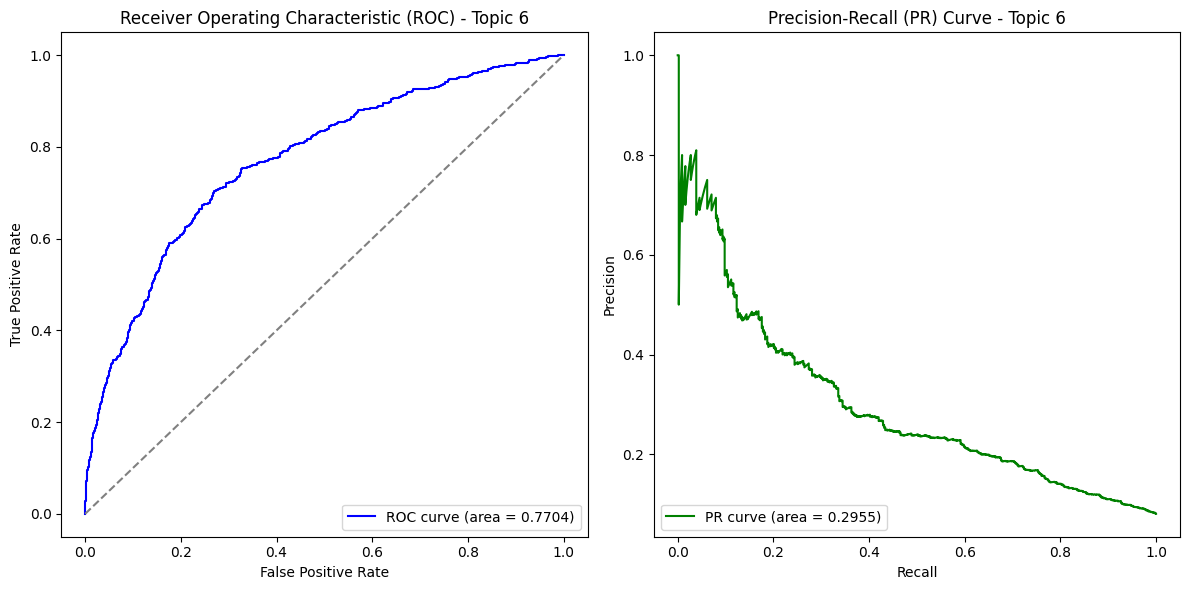

Evaluating topic 7
Topic 7 - auROC: 0.7484, auPR: 0.3173, F1: 0.1434


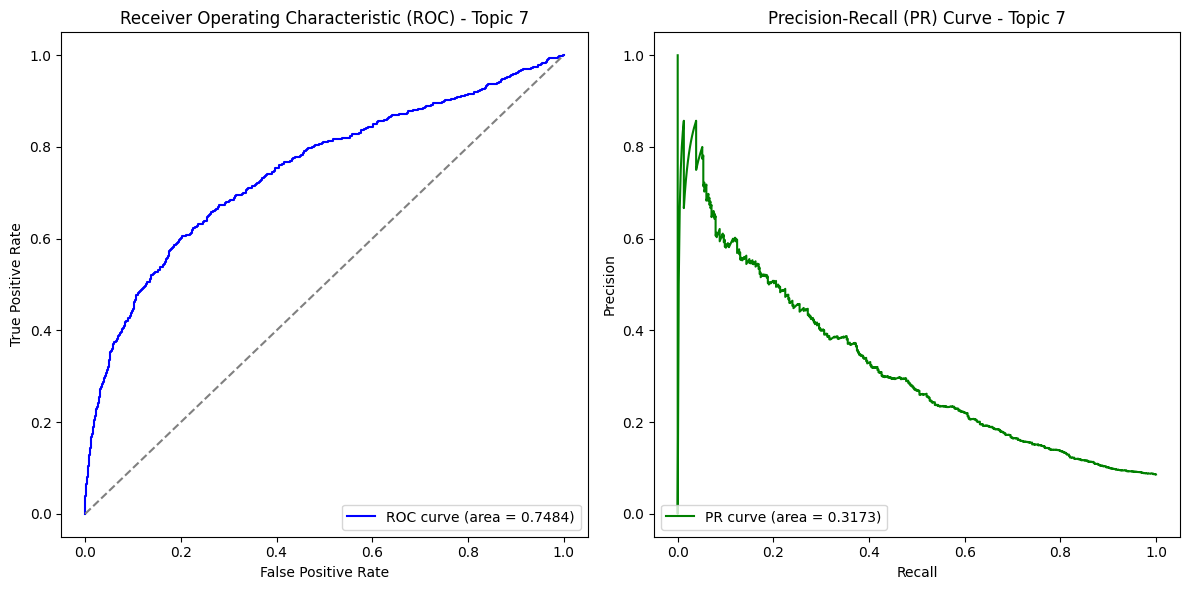

Evaluating topic 8
Topic 8 - auROC: 0.6929, auPR: 0.2116, F1: 0.0812


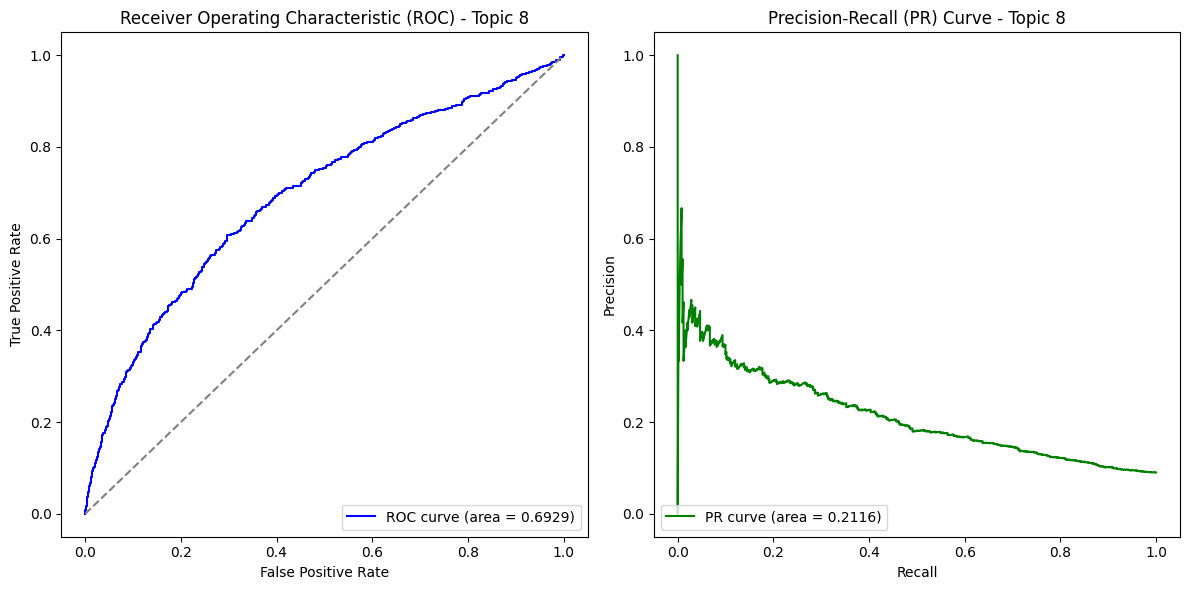

Evaluating topic 9
Topic 9 - auROC: 0.7686, auPR: 0.2715, F1: 0.2397


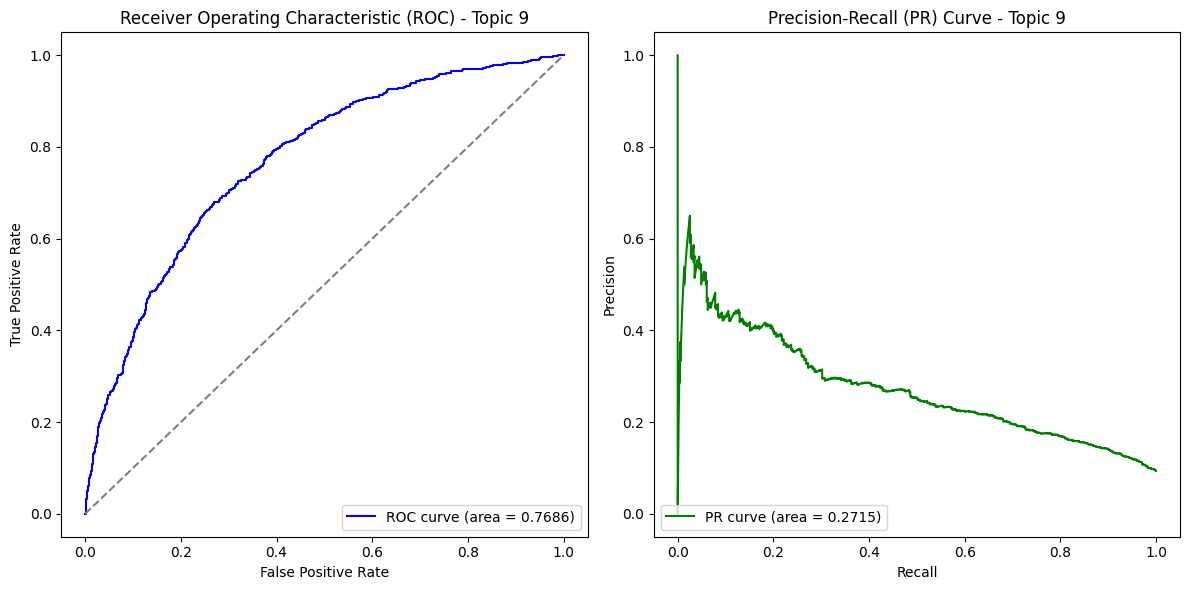

Evaluating topic 10
Topic 10 - auROC: 0.9223, auPR: 0.7465, F1: 0.7100


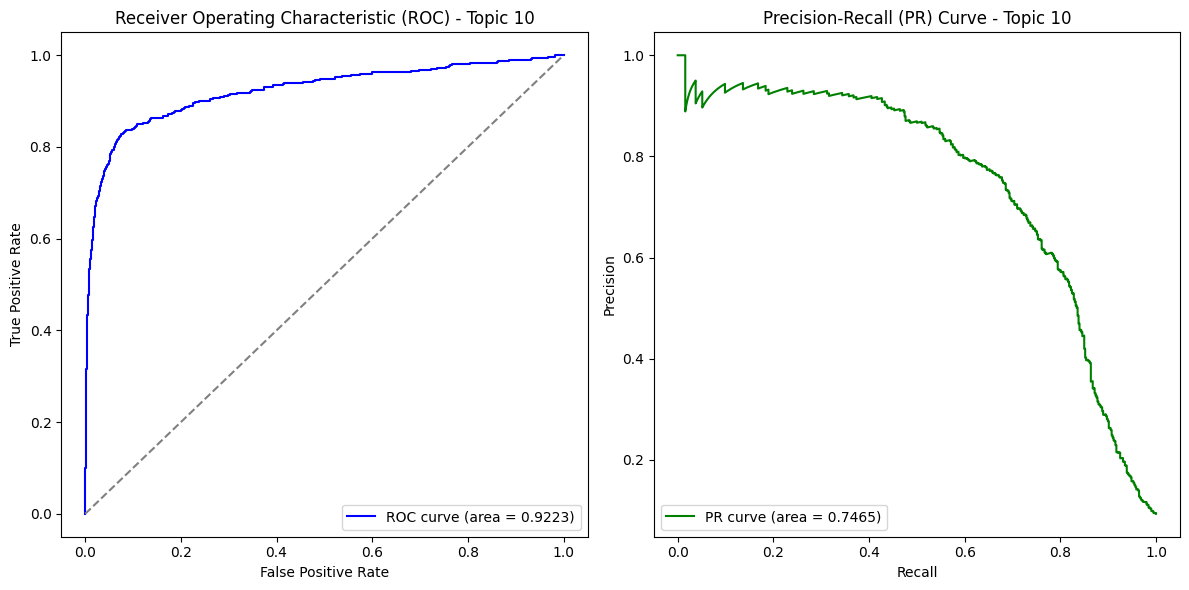

Evaluating topic 11
Topic 11 - auROC: 0.8216, auPR: 0.4327, F1: 0.4168


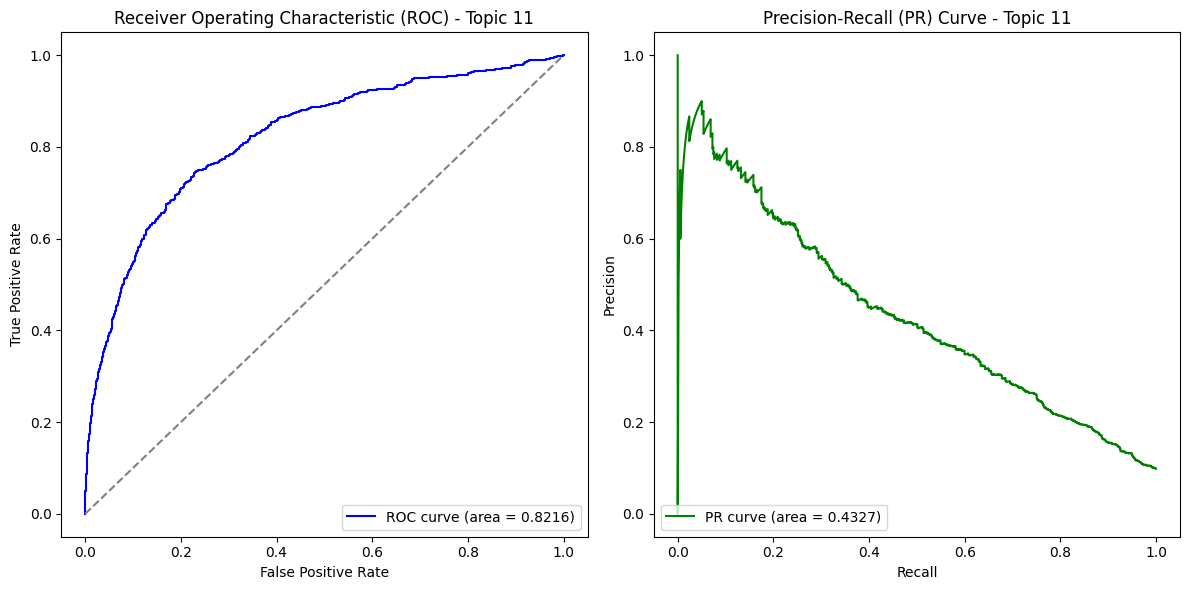

Evaluating topic 12
Topic 12 - auROC: 0.6824, auPR: 0.2110, F1: 0.0665


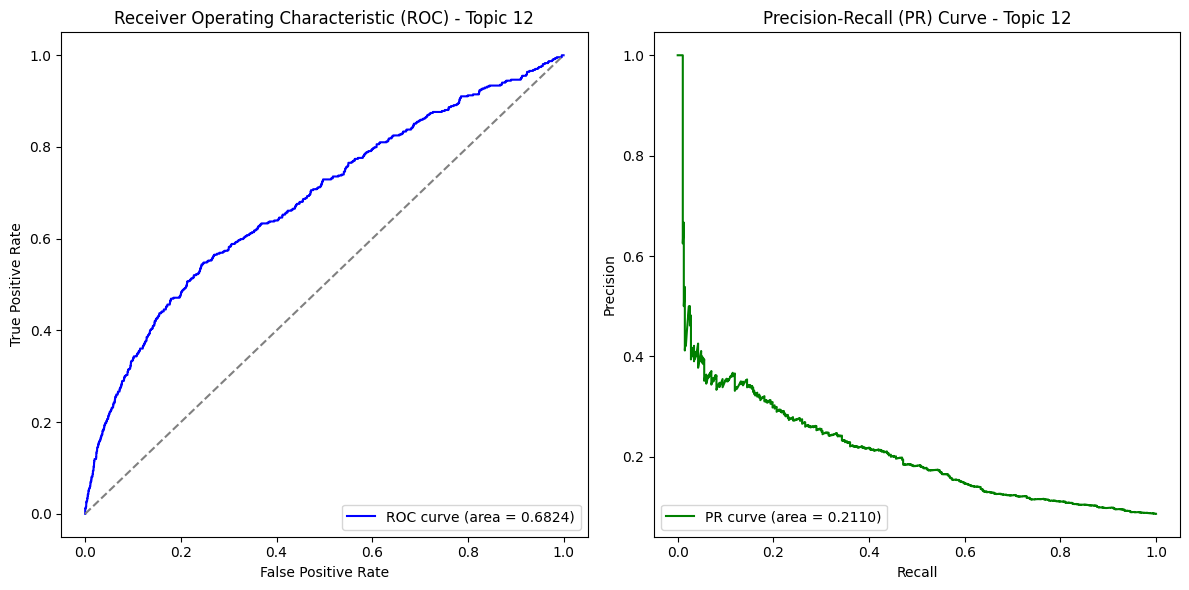

Evaluating topic 13
Topic 13 - auROC: 0.6764, auPR: 0.2039, F1: 0.0850


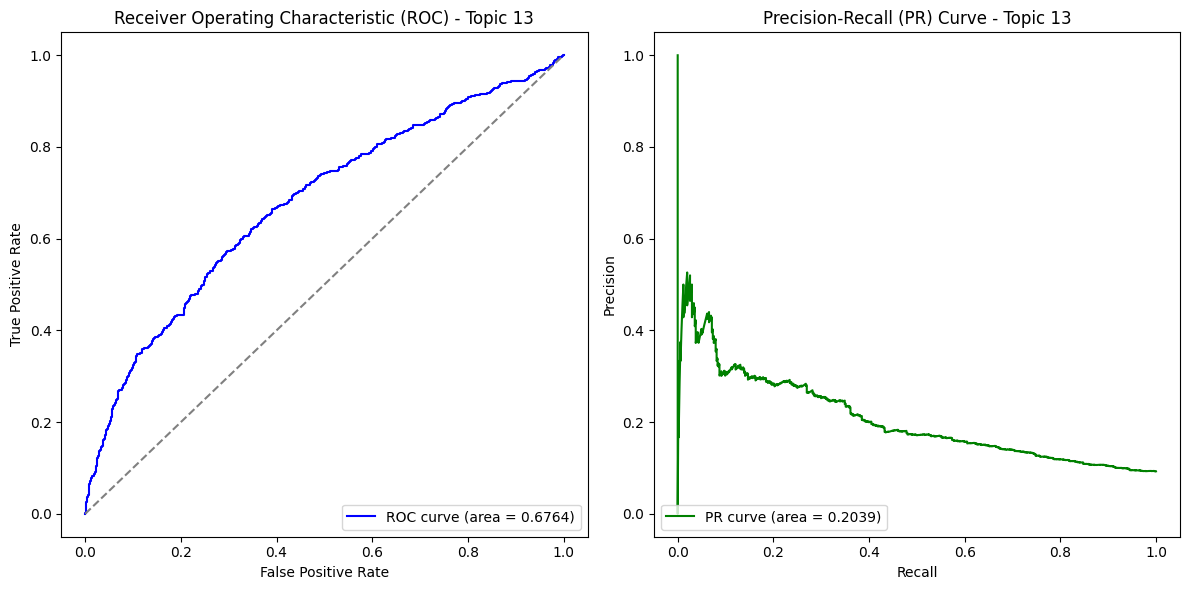

Evaluating topic 14
Topic 14 - auROC: 0.9141, auPR: 0.7066, F1: 0.6756


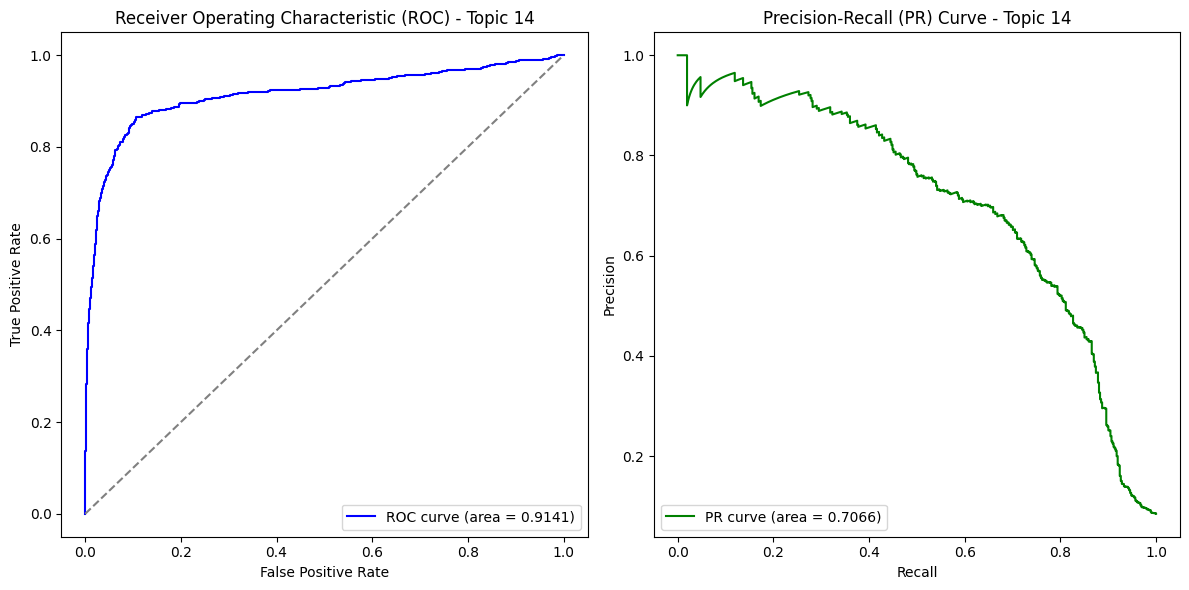

In [27]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [28]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.7851 ± 0.0735
Mean auPR: 0.3804 ± 0.1661
Mean F1: 0.3233 ± 0.1951
Exact Match Accuracy: 0.0363
Hamming Accuracy: 0.9118


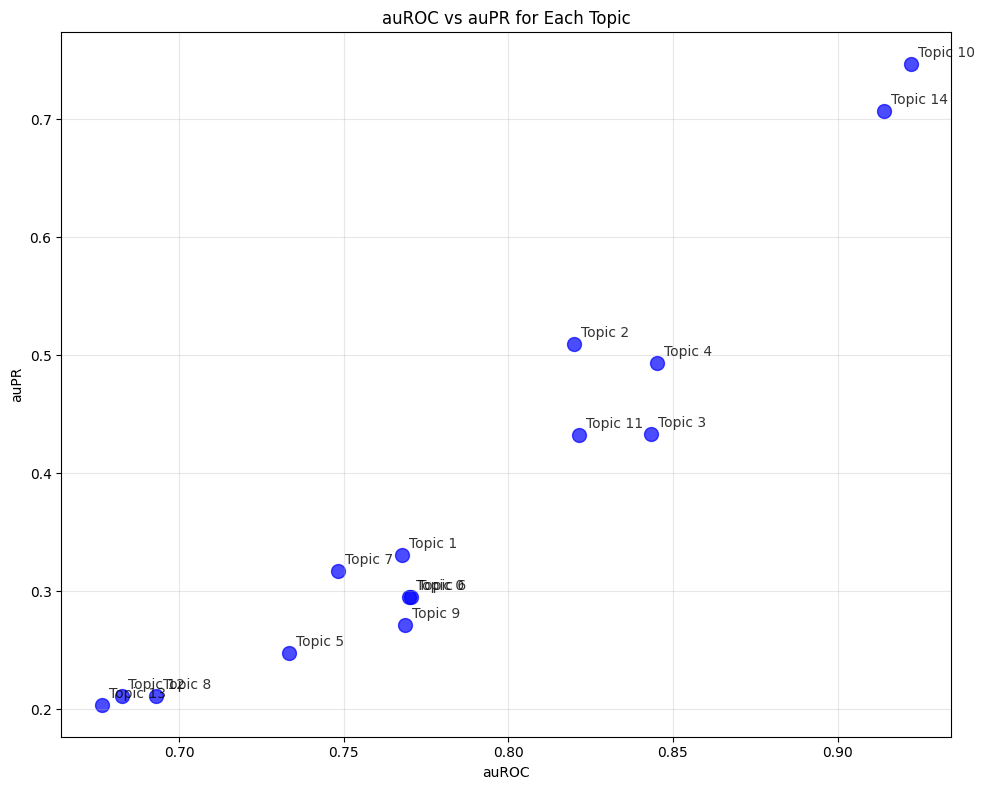

In [29]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

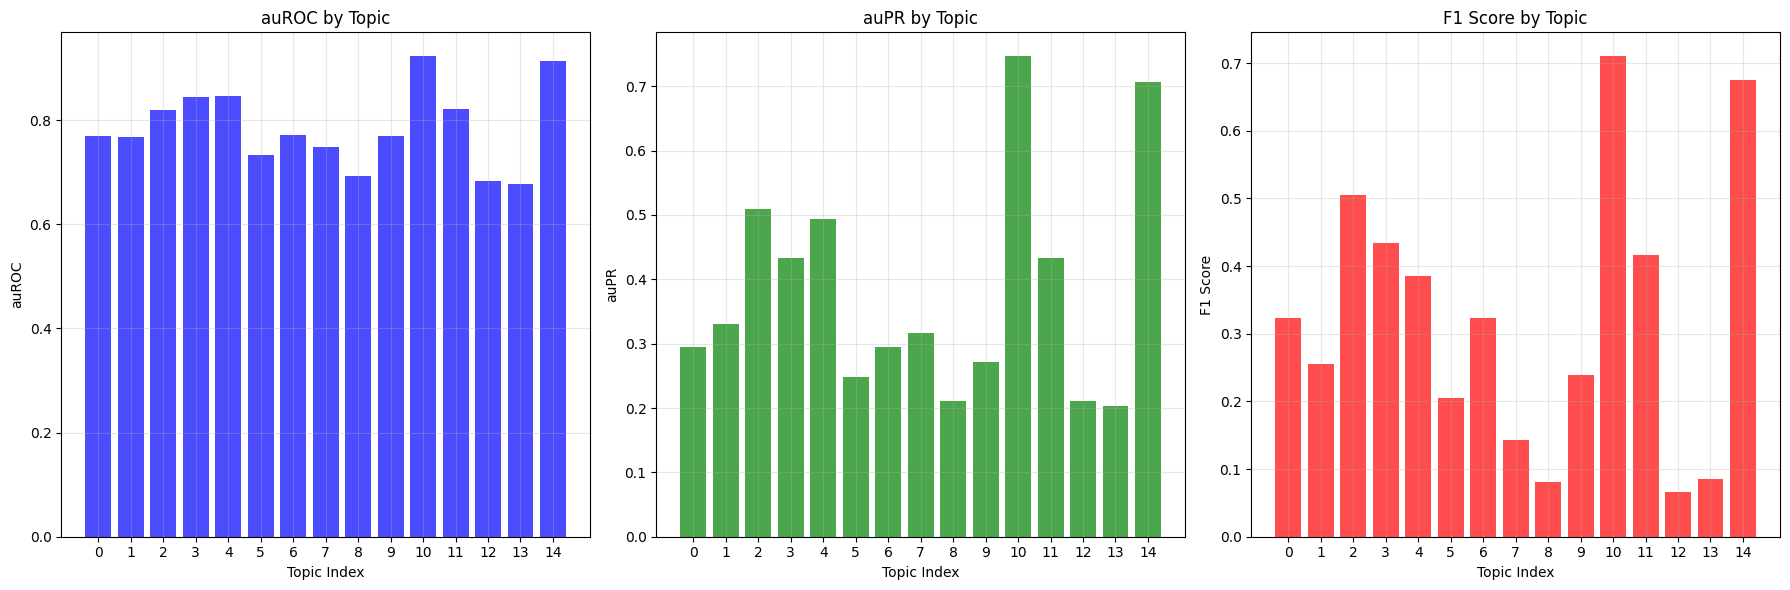

In [30]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

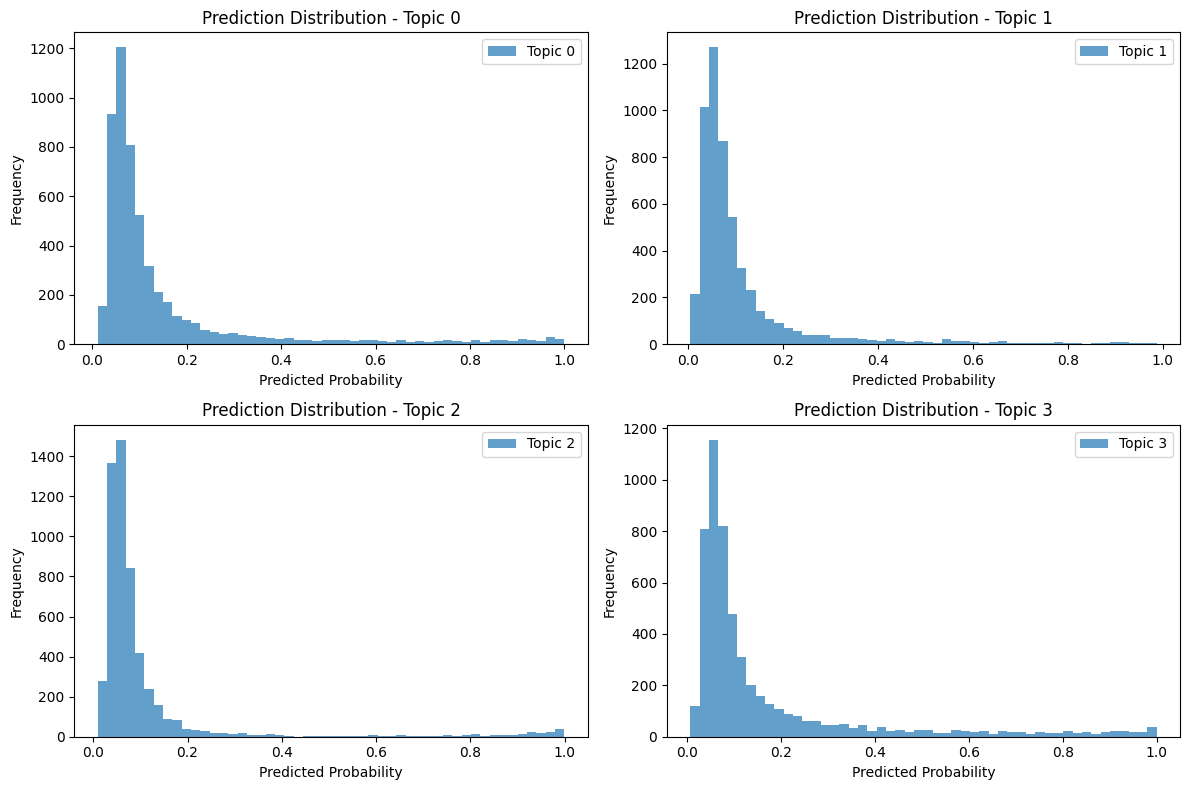


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.12605144 0.07574188 0.10061276 0.14852811 0.04342897 0.09880702
 0.07935366 0.08391498 0.08750563 0.15858719 0.05380419 0.39661363
 0.05553446 0.1340493  0.14249548]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.06743673 0.04813    0.03036809 0.88554657 0.14830482 0.12797223
 0.05288434 0.03353918 0.08694643 0.07382086 0.09212407 0.14554295
 0.07386497 0.0586163  0.05407962]
  Actual:    [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.03787509 0.02111598 0.60244566 0.06553943 0.03219538 0.01875609
 0.05175759 0.03060246 0.0437186  0.05415529 0.03150382 0.79870546
 0.04473965 0.01549944 0.04423777]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]

Sample 3:
  Predicted: [0.05069448 0.01969682 0.04835514 0.1218864

In [31]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()